<a href="https://colab.research.google.com/github/dcpatton/Image-Classification/blob/master/patch_camelyon_effiecientnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import random

seed = 52
tf.random.set_seed(seed)
random.seed(seed)

print('TensorFlow version: ' + tf.__version__)

TensorFlow version: 2.3.0


# Data

In [2]:
train_ds, val_ds, test_ds = tfds.load('patch_camelyon', split=['train', 'validation', 'test'], shuffle_files=True, as_supervised=True, try_gcs=True)

In [3]:
# # balanced?
# label_0 = 0
# label_1 = 0
# for image, label in train_ds:
#   if label.numpy() == 0:
#     label_0 += 1
#   else:
#     label_1 += 1

# print(label_0)
# print(label_1)

In [4]:
BATCH_SIZE = 32

train_ds = train_ds.shuffle(1024)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(tf.data.experimental.AUTOTUNE)

# Model

In [5]:
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, GaussianNoise
from tensorflow.keras import Input, Model
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomFlip, RandomContrast, RandomZoom
from tensorflow.keras.layers.experimental.preprocessing import CenterCrop, Rescaling, Resizing
from tensorflow.keras.regularizers import l2

model_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
hub_layer = hub.KerasLayer(model_url, trainable=False)

inp = Input(shape=(96, 96, 3))
# x = CenterCrop(64, 64)(inp)
x = Resizing(224, 224)(inp)  # default size for EfficientNet B0
# x = RandomRotation(0.2)(x)
# x = RandomFlip(mode='horizontal_and_vertical')(x)
# x = RandomContrast(0.1)(x)
# x = RandomZoom(height_factor=0.1, width_factor=0.1)(x)
x = Rescaling(scale=1./255., offset=0.0)(x)
# x = GaussianNoise(stddev=0.2)(x)
x = hub_layer(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
# x = Dropout(0.25)(x)
# x = BatchNormalization()(x)
out = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[inp], outputs=[out])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 1280)              4049564   
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 4,131,613
Trainable params: 82,049
Non-trainable params: 4,049,564
_______________________________________

In [6]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

# Training

In [7]:
es = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1, restore_best_weights=True)

history = model.fit(train_ds, epochs=200, validation_data=val_ds, callbacks=[es])

Epoch 1/200
8192/8192 [==============================] - 278s 34ms/step - loss: 0.3305 - auc: 0.9471 - val_loss: 0.3945 - val_auc: 0.9232
Epoch 2/200
8192/8192 [==============================] - 286s 35ms/step - loss: 0.3007 - auc: 0.9565 - val_loss: 0.3987 - val_auc: 0.9330
Epoch 3/200
8192/8192 [==============================] - 271s 33ms/step - loss: 0.2907 - auc: 0.9595 - val_loss: 0.3955 - val_auc: 0.9233
Epoch 4/200
8192/8192 [==============================] - 269s 33ms/step - loss: 0.2861 - auc: 0.9607 - val_loss: 0.3867 - val_auc: 0.9246
Epoch 5/200
8192/8192 [==============================] - 261s 32ms/step - loss: 0.2835 - auc: 0.9613 - val_loss: 0.4042 - val_auc: 0.9253
Epoch 6/200
8192/8192 [==============================] - 251s 31ms/step - loss: 0.2808 - auc: 0.9620 - val_loss: 0.4025 - val_auc: 0.9198
Epoch 7/200
8192/8192 [==============================] - 255s 31ms/step - loss: 0.2797 - auc: 0.9621 - val_loss: 0.3560 - val_auc: 0.9364
Epoch 8/200
8192/8192 [===========

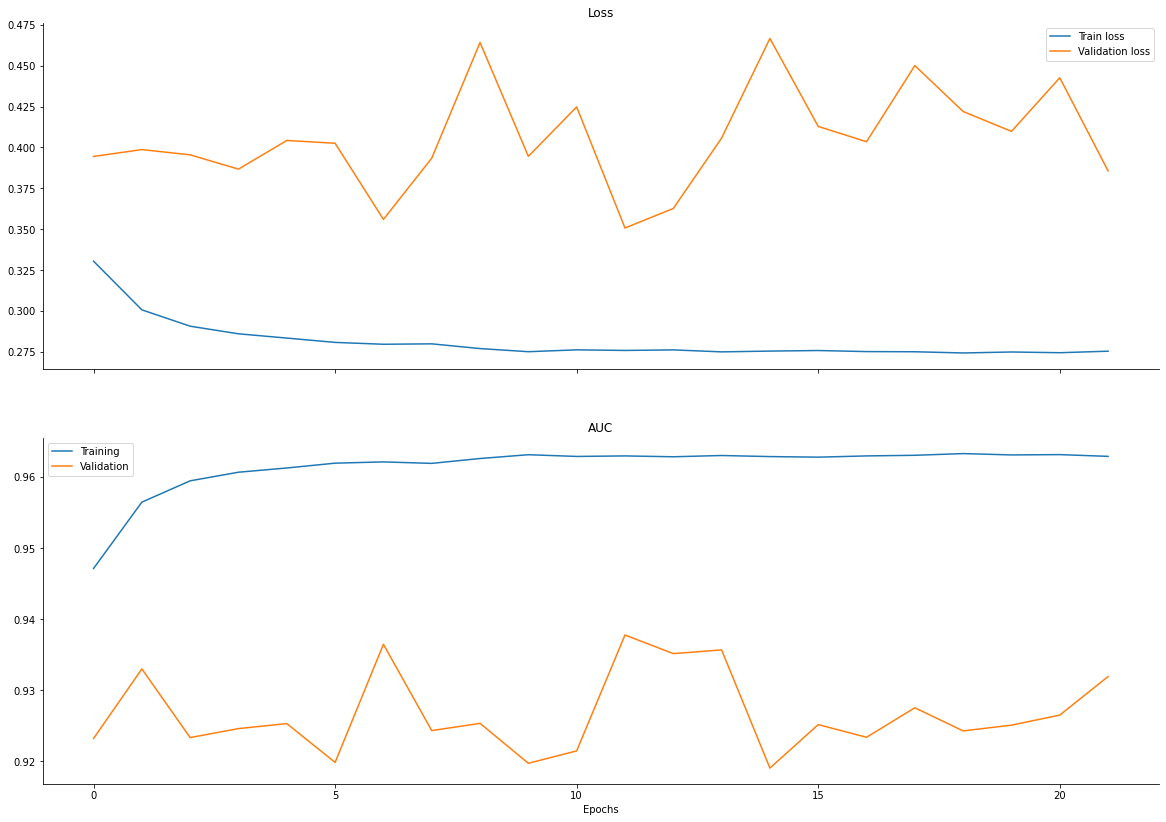

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['auc'], label='Training')
ax2.plot(history['val_auc'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('AUC')

plt.xlabel('Epochs')
sns.despine()
plt.show()

# Evaluation

In [9]:
model.evaluate(test_ds, verbose=1)

1024/1024 [==============================] - 29s 28ms/step - loss: 0.3964 - auc: 0.9216


[0.3964269757270813, 0.9215747714042664]

* baseline:              loss: 0.3861 - auc: 0.9146
* randomflip:            loss: 0.3910 - auc: 0.9139
* no resizing:           loss: 0.4133 - auc: 0.8965
* rotation(0.2):         loss: 0.5022 - auc: 0.9015
* batchnorm:             loss: 0.3916 - auc: 0.9132
* Dropout(0.5):          loss: 0.3793 - auc: 0.9105
* Dropout(0.25):         **loss: 0.3672 - auc: 0.9171**
* 32x32Crop-noresize:    loss: 0.5108 - auc: 0.8301
* 32x32Crop-resized:     loss: 0.4753 - auc: 0.8560
* 64x64Crop-resized:     loss: 0.3898 - auc: 0.9071
* Add Dense(32):         **loss: 0.4054 - auc: 0.9253**
* Dense(64):             loss: 0.3849 - auc: 0.9170
* l2(0.001):             loss: 0.3964 - auc: 0.9216
* RandomContrast(0.1):
* ensemble
* TTA
